In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math
import time

In [3]:
df = pd.read_csv('data/loureiro_40casas.csv')
df

,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.164,0.072,0.055,0.006,0.080,0.062,...,0.052,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.135,0.058,0.060,0.006,0.056,0.062,...,0.052,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.121,0.011,0.096,0.006,0.052,0.062,...,0.052,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.138,0.010,0.064,0.006,0.052,0.062,...,0.052,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.104,0.011,0.072,0.006,0.053,0.062,...,0.052,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 01:15:00,0.120,0.020,0.066,0.120,0.003,0.094,0.037,0.045,0.071,...,0.047,0.054,0.004,0.080,0.014,0.028,0.066,0.058,0.000,0.003
38015,2023-06-07 01:30:00,0.121,0.004,0.057,0.087,0.002,0.077,0.036,0.046,0.059,...,0.051,0.038,0.004,0.060,0.028,0.023,0.067,0.032,0.016,0.004
38016,2023-06-07 01:45:00,0.158,0.007,0.056,0.086,0.003,0.087,0.021,0.045,0.059,...,0.068,0.045,0.004,0.057,0.029,0.043,0.065,0.495,0.008,0.003
38017,2023-06-07 02:00:00,0.102,0.042,0.056,0.085,0.002,0.072,0.027,0.045,0.059,...,0.067,0.053,0.003,0.061,0.012,0.047,0.041,0.274,0.000,0.004


In [4]:
df_location = pd.read_csv("data/loureiro_40casas_location.csv")
df_location

,Time,Energy,Location
0,2022-05-05 12:00:00,0.068,Energy_1
1,2022-05-05 12:15:00,0.070,Energy_1
2,2022-05-05 12:30:00,0.122,Energy_1
3,2022-05-05 12:45:00,0.132,Energy_1
4,2022-05-05 13:00:00,0.125,Energy_1
...,...,...,...
1520755,2023-06-07 01:15:00,0.003,Energy_164
1520756,2023-06-07 01:30:00,0.004,Energy_164
1520757,2023-06-07 01:45:00,0.003,Energy_164
1520758,2023-06-07 02:00:00,0.004,Energy_164


In [9]:
num_samples_per_house = df_location.Location.value_counts()[0]
num_houses = df_location.Location.nunique()

In [10]:
def no_ml_predict(X: np.array, y: np.array):
    mse = truncate_metric(mean_squared_error(X, y))
    #wape = mean_absolute_error(X,y) / y.mean()
    wape = truncate_metric(float(np.sum(np.abs(X - y)) / np.sum(np.abs(y))))
    r2 = truncate_metric(r2_score(X, y))
    
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % (wape * 100))
    print('R2: %.4f' % r2)
    return mse, wape, r2


def truncate_metric(metric):
    m = math.trunc(10000*metric) / 10000
    return m

def truncate(df):
    trunc = lambda x: math.trunc(10000*x) / 10000
    df_trunc = df.applymap(trunc)
    return df_trunc

def truncate_location(df):
    trunc = lambda x: math.trunc(10000*x) / 10000
    df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
    df = pd.concat([df.iloc[:,0:-1], df_trunc],axis=1)
    return df
    
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
def total_averaged_metrics(metrics_list):
    mse = np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)
    wape = np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)
    r2 = np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)
    print("Total Averaged MSE: {}".format(mse))
    print("Total Averaged WAPE: {}".format(wape * 100))
    print("Total Averaged R2: {}".format(r2))
    return mse, wape, r2

In [11]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [12]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,2.955
1,2.652
2,2.593
3,2.691
4,2.685
...,...
38014,1.820
38015,1.751
38016,2.252
38017,2.034


## Individual 51 houses preprocessing
### Previous 15 minutes

In [13]:
X15 = df_location.copy()
for i in range(1, num_houses):
    X15.iloc[(num_samples_per_house*i)-1] = np.nan
X15.dropna(inplace=True)
m = len(X15)
X15 = X15.iloc[0:(m-1)]
X15.drop(["Time", "Location"],inplace=True, axis=1)
X15.reset_index(drop=True, inplace=True)
X15

,Energy
0,0.068
1,0.070
2,0.122
3,0.132
4,0.125
...,...
1520715,0.004
1520716,0.003
1520717,0.004
1520718,0.003


In [14]:
y15 = df_location.copy()
for i in range(1, num_houses):
    y15.iloc[(num_samples_per_house*i)] = np.nan
y15.dropna(inplace=True)
y15 = y15.iloc[1:].reset_index(drop=True)
y15.drop(["Time", "Location"],inplace=True, axis=1)
y15.reset_index(drop=True, inplace=True)
y15

,Energy
0,0.070
1,0.122
2,0.132
3,0.125
4,0.089
...,...
1520715,0.003
1520716,0.004
1520717,0.003
1520718,0.004


### Previous day at same hour

In [15]:
Xday = df_location.copy()
for i in range(1, num_houses):
    Xday.iloc[(num_samples_per_house*i)-1] = np.nan
Xday.dropna(inplace=True)
m = len(Xday)
Xday = Xday.iloc[0:(m-96)]
Xday.drop(["Time", "Location"],inplace=True, axis=1)
Xday.reset_index(drop=True, inplace=True)
Xday

,Energy
0,0.068
1,0.070
2,0.122
3,0.132
4,0.125
...,...
1520620,0.004
1520621,0.003
1520622,0.004
1520623,0.004


In [16]:
yday = df_location.copy()
for i in range(1, num_houses):
    yday.iloc[(num_samples_per_house*i)] = np.nan
yday.dropna(inplace=True)
yday = yday.iloc[96:].reset_index(drop=True)
yday.drop(["Time", "Location"],inplace=True, axis=1)
yday.reset_index(drop=True, inplace=True)
yday

,Energy
0,0.099
1,0.083
2,0.067
3,0.093
4,0.127
...,...
1520620,0.003
1520621,0.004
1520622,0.003
1520623,0.004


### Previous week same day and same hour

In [17]:
Xweek = df_location.copy()
for i in range(1, num_houses):
    Xweek.iloc[(num_samples_per_house*i)-1] = np.nan
Xweek.dropna(inplace=True)
m = len(Xweek)
Xweek = Xweek.iloc[0:(m-672)]
Xweek.drop(["Time", "Location"],inplace=True, axis=1)
Xweek.reset_index(drop=True, inplace=True)
Xweek

,Energy
0,0.068
1,0.070
2,0.122
3,0.132
4,0.125
...,...
1520044,0.004
1520045,0.003
1520046,0.004
1520047,0.004


In [18]:
yweek = df_location.copy()
for i in range(1, num_houses):
    yweek.iloc[(num_samples_per_house*i)] = np.nan
yweek.dropna(inplace=True)
yweek = yweek.iloc[672:].reset_index(drop=True)
yweek.drop(["Time", "Location"],inplace=True, axis=1)
yweek.reset_index(drop=True, inplace=True)
yweek

,Energy
0,0.040
1,0.037
2,0.064
3,0.062
4,0.045
...,...
1520044,0.003
1520045,0.004
1520046,0.003
1520047,0.004


## Prediction organized by location
### Previous 15 minutes

In [19]:
X15_norm, scaler = normalize_training(X15)
y15_norm = scaler.transform(y15)
X15_norm

array([[0.03207547],
       [0.03301887],
       [0.05754717],
       ...,
       [0.00188679],
       [0.00141509],
       [0.00188679]])

In [20]:
mse_15_norm, wape_15_norm, r2_15_norm = no_ml_predict(X15_norm, y15_norm)

MSE: 0.0013
WAPE: 38.38
R2: 0.5838


In [21]:
mse_15, wape_15, r2_15 = no_ml_predict(X15, y15)

MSE: 0.0059
WAPE: 38.38
R2: 0.5838


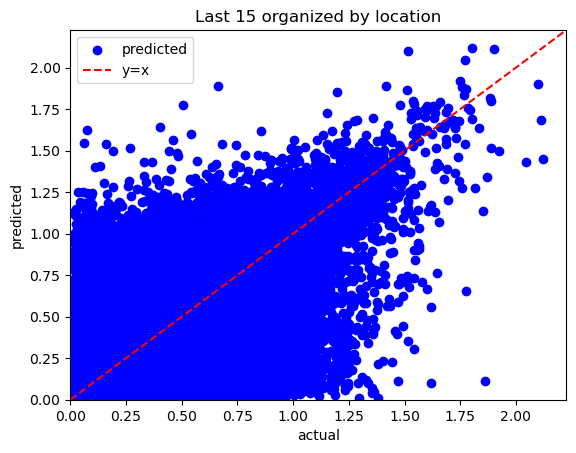

In [22]:
plot_results(X15, y15, "Last 15 organized by location")

### Previous day at same hour

In [23]:
Xday_norm, scaler = normalize_training(Xday)
yday_norm = scaler.transform(yday)
Xday_norm

array([[0.03207547],
       [0.03301887],
       [0.05754717],
       ...,
       [0.00188679],
       [0.00188679],
       [0.00141509]])

In [24]:
mse_day_norm, wape_day_norm, r2_day_norm = no_ml_predict(Xday_norm, yday_norm)

MSE: 0.0032
WAPE: 66.42
R2: -0.0400


In [25]:
mse_day, wape_day, r2_day = no_ml_predict(Xday, yday)

MSE: 0.0147
WAPE: 66.42
R2: -0.0400


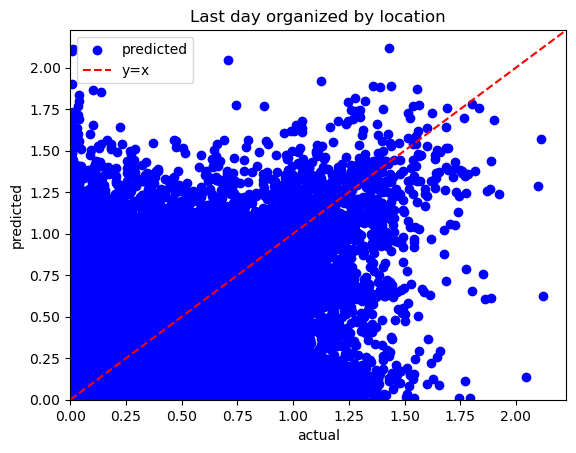

In [26]:
plot_results(Xday, yday, "Last day organized by location")

### Previous week same day and same hour

In [27]:
Xweek_norm, scaler = normalize_training(Xweek)
yweek_norm = scaler.transform(yweek)
Xweek_norm

array([[0.03207547],
       [0.03301887],
       [0.05754717],
       ...,
       [0.00188679],
       [0.00188679],
       [0.00188679]])

In [28]:
mse_week_norm, wape_week_norm, r2_week_norm = no_ml_predict(Xweek_norm, yweek_norm)

MSE: 0.0035
WAPE: 67.98
R2: -0.1118


In [29]:
mse_week, wape_week, r2_week = no_ml_predict(Xweek, yweek)

MSE: 0.0157
WAPE: 67.98
R2: -0.1118


/home/francisco.monteiro@av.it.pt/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


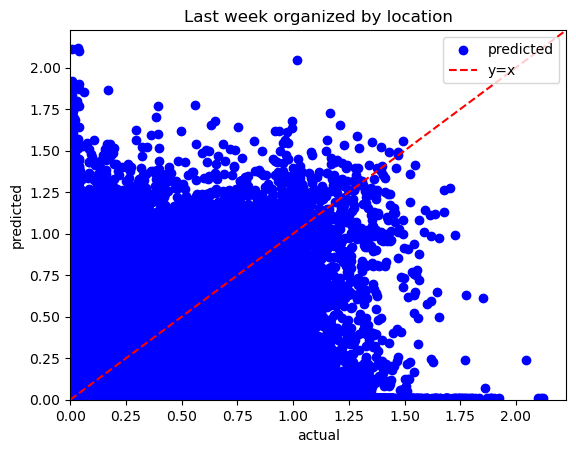

In [30]:
plot_results(Xweek, yweek, "Last week organized by location")

# Sum of all houses preprocessing
### Previous 15 minutes prediction data

In [31]:
X_total_15 = df_total.copy()
m = len(X_total_15)
X_total_15 = X_total_15.iloc[0:(m-1)]
X_total_15

,Energy
0,2.955
1,2.652
2,2.593
3,2.691
4,2.685
...,...
38013,2.005
38014,1.820
38015,1.751
38016,2.252


In [32]:
y_total_15 = df_total.copy()
y_total_15 = y_total_15.iloc[1:].reset_index(drop=True)
y_total_15

,Energy
0,2.652
1,2.593
2,2.691
3,2.685
4,3.438
...,...
38013,1.820
38014,1.751
38015,2.252
38016,2.034


In [33]:
X_total_15_norm, scaler = normalize_training(X_total_15)
y_total_15_norm = scaler.transform(y_total_15)

### Previous day at same hour prediction data

In [34]:
X_total_prev_day = df_total.copy()
m = len(X_total_prev_day)
X_total_prev_day = X_total_prev_day.iloc[0:(m-96)]
X_total_prev_day

,Energy
0,2.955
1,2.652
2,2.593
3,2.691
4,2.685
...,...
37918,3.076
37919,2.368
37920,2.801
37921,3.054


In [35]:
y_total_prev_day = df_total.copy()
y_total_prev_day = y_total_prev_day.iloc[96:].reset_index(drop=True)
y_total_prev_day[:15]

,Energy
0,4.163
1,4.852
2,4.787
3,4.414
4,3.605
5,4.016
6,4.704
7,4.216
8,3.721
9,3.480


In [36]:
X_total_prev_day_norm, scaler = normalize_training(X_total_prev_day)
y_total_prev_day_norm = scaler.transform(y_total_prev_day)

### Previous week same day at same hour prediction data

In [37]:
X_total_prev_week = df_total.copy()
m = len(X_total_prev_week)
X_total_prev_week = X_total_prev_week.iloc[0:(m-96*7)]
X_total_prev_week

,Energy
0,2.955
1,2.652
2,2.593
3,2.691
4,2.685
...,...
37342,1.754
37343,1.966
37344,2.108
37345,3.740


In [38]:
y_total_prev_week = df_total.copy()
y_total_prev_week = y_total_prev_week.iloc[(96*7):].reset_index(drop=True)
y_total_prev_week

,Energy
0,4.238
1,5.024
2,4.433
3,3.898
4,3.810
...,...
37342,1.820
37343,1.751
37344,2.252
37345,2.034


In [39]:
X_total_prev_week_norm, scaler = normalize_training(X_total_prev_week)
y_total_prev_week_norm = scaler.transform(y_total_prev_week)

## Prediction (sum of all houses)

#### R2 will be negative whenever your model's predictions are worse than a constant function that always predicts the mean of the data.

### Previous 15 minutes prediction data

In [40]:
mse_total_15_norm, wape_total_15_norm, r2_total_15_norm = no_ml_predict(X_total_15_norm, y_total_15_norm)

MSE: 0.0028
WAPE: 12.50
R2: 0.7361


In [41]:
mse_total_15, wape_total_15, r2_total_15 = no_ml_predict(X_total_15, y_total_15)

MSE: 0.3615
WAPE: 12.50
R2: 0.7361


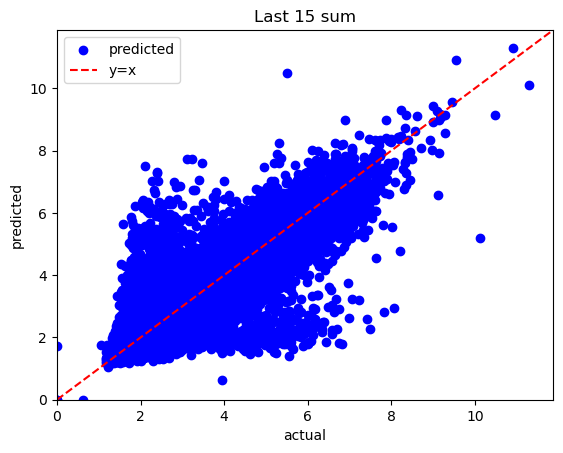

In [42]:
plot_results(X_total_15, y_total_15, "Last 15 sum")

### Previous day at same hour prediction data

In [43]:
mse_total_prev_day_norm, wape_total_prev_day_norm, r2_total_prev_day_norm = no_ml_predict(X_total_prev_day_norm, y_total_prev_day_norm)

MSE: 0.0051
WAPE: 18.96
R2: 0.5153


In [44]:
mse_total_prev_day, wape_total_prev_day, r2_total_prev_day = no_ml_predict(X_total_prev_day, y_total_prev_day)

MSE: 0.6644
WAPE: 18.96
R2: 0.5153


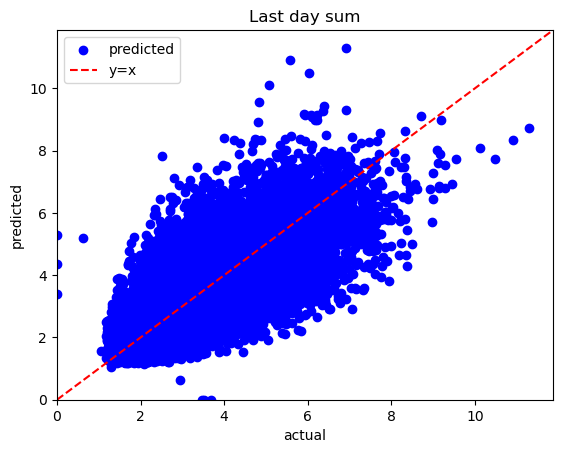

In [45]:
plot_results(X_total_prev_day, y_total_prev_day, "Last day sum")

### Previous week same day at same hour prediction data

In [46]:
mse_total_prev_week_norm, wape_total_prev_week_norm, r2_total_prev_week_norm = no_ml_predict(X_total_prev_week_norm, y_total_prev_week_norm)

MSE: 0.0057
WAPE: 19.78
R2: 0.4680


In [47]:
mse_total_prev_week, wape_total_prev_week, r2_total_prev_week = no_ml_predict(X_total_prev_week, y_total_prev_week)

MSE: 0.7335
WAPE: 19.78
R2: 0.4680


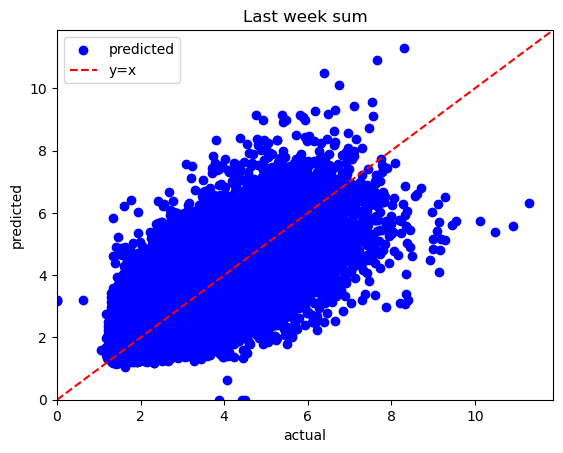

In [48]:
plot_results(X_total_prev_week, y_total_prev_week, "Last week sum")

## Comparison between individual and sum

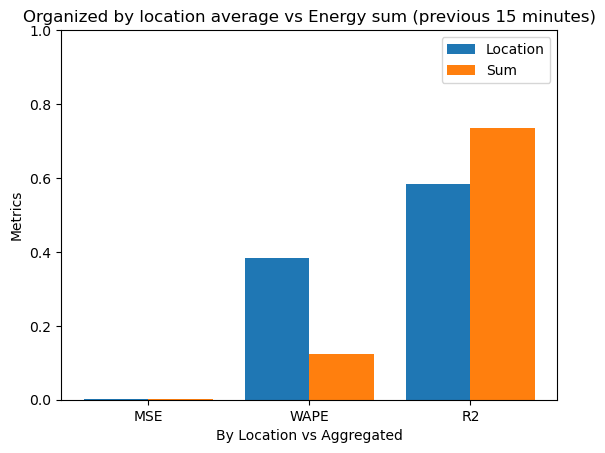

In [49]:
X_names = ("MSE", "WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (mse_15_norm, wape_15, r2_15), 0.4, label = 'Location')
plt.bar(X_axis + 0.2, (mse_total_15_norm, wape_total_15, r2_total_15), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("By Location vs Aggregated")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Organized by location average vs Energy sum (previous 15 minutes)")
plt.legend()
plt.show()

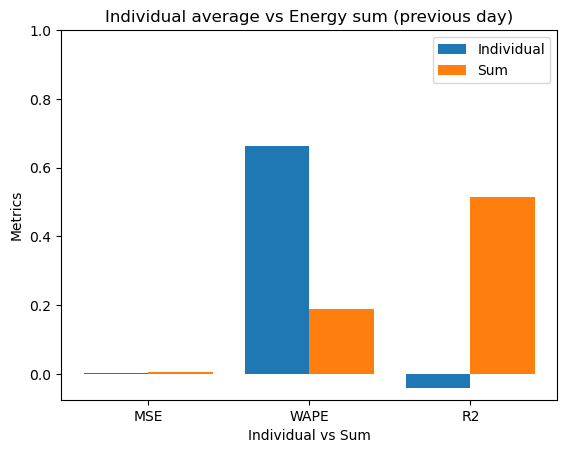

In [50]:
plt.bar(X_axis - 0.2, (mse_day_norm, wape_day, r2_day), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (mse_total_prev_day_norm, wape_total_prev_day, r2_total_prev_day), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Individual average vs Energy sum (previous day)")
plt.legend()
plt.show()

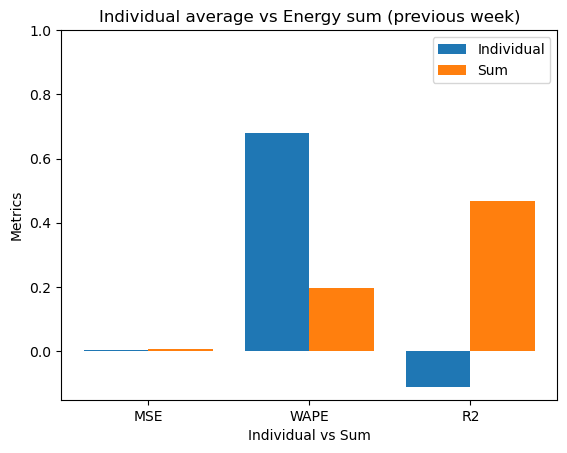

In [51]:
plt.bar(X_axis - 0.2, (mse_week_norm, wape_week, r2_week), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (mse_total_prev_week_norm, wape_total_prev_week, r2_total_prev_week), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Individual average vs Energy sum (previous week)")
plt.legend()
plt.show()

In [52]:
names_alg = ["No ML - Previous 15\n", "No ML - Previous Day\n", "No ML - Previous Week\n"]
all_metrics = [(mse_15, wape_15, r2_15), (mse_day, wape_day, r2_day), (mse_week, wape_week, r2_week)]
all_metrics_agg = [(mse_total_15_norm, wape_total_15, r2_total_15), (mse_total_prev_day_norm, wape_total_prev_day, r2_total_prev_day), (mse_total_prev_week_norm, wape_total_prev_week, r2_total_prev_week)]

In [54]:
with open('gpu_logs/no_ml_loureiro.txt', 'w') as file:
    for i in range(0, 3):
        file.write(names_alg[i])
        file.write("No_ML\n")
        mse_msg = "MSE: " + str(all_metrics[i][0]) + "\n"
        wape_msg = "WAPE: " + str(all_metrics[i][1]) + "\n"
        r2_msg = "R2: " + str(all_metrics[i][2]) + "\n"
        file.write(mse_msg)
        file.write(wape_msg)
        file.write(r2_msg)
        file.write("No_ML_Aggregated\n")
        mse_msg_agg = "MSE: " + str(all_metrics_agg[i][0]) + "\n"
        wape_msg_agg = "WAPE: " + str(all_metrics_agg[i][1]) + "\n"
        r2_msg_agg = "R2: " + str(all_metrics_agg[i][2]) + "\n"
        file.write(mse_msg_agg)
        file.write(wape_msg_agg)
        file.write(r2_msg_agg)